# *MultipathLocationEstimator* First Tutorial: Getting Started

*MultipathLocationEstimator* is an open-source Python class for location in multipath channels, which contains several estimation algorithms for UE **(User Equipment)** positioning. The official documentation can be found [here](https://github.com/gomezcuba/CASTRO-5G/tree/main). This document is a tutorial in Jupyter Notebook that helps users understand the internal logic and intended use of this class, divided in two parts:


1. [First tutorial](./Tutorial_1_MultipathLocationEstimator.ipynb): This first tutorial is focused in understanding the definition of the channel parameters between the BS (Base Station) and the UE. In other words, how it is established the coordinates and geometric system without going into detail in how the user position is computed.
2. [Second tutorial](./Tutorial_2_MultipathLocationEstimator.ipynb): The second tutorial is focused on understanding how UE position is estimated and computed from the channel parameters. For this purpose, <i>MultipathLocationEstimator</i> class includes different estimation algorithms that will be described along the notebook, as well as a comparison of their performance, time execution and precision in the results.

In this first tutorial you will learn how to:
1. Plot the geometric system representation
2. Understand the problem of UE offset orientation
3. Understand the relation between DAoA and $\phi_0$
4. Generate random positions for the UE
5. Generate random positions for the scatters
6. Obtain the value of channel parameters

## Table of Contents:

1. [System Model](#1.-System-Model)
2. [Representation of a single path](#2.-Representation-of-a-single-path)
3. [One multipath ray with random UE orientation](#3.-One-multipath-ray-with-random-UE-orientation)
5. <a href="#2.2-Constant-offset-error-model">Constant offset error model</a>
    * 2.2.1. <a href="#B">One multipath ray with random offset orientation</a>
    * 2.2.2. <a href="#C">N multipath ray with random offset orientation</a>
6. <a href="#References">References</a>

## 1. System Model

The main goal of the <i>MultipathLocationEstimator</i> class is try to recover the UE position trigonometrically. The location, in a 2D scenario, is denoted as $(d_{0x},d_{0y})$. Moreover the UE is rotated with an <b>UE offset orientation</b> $\phi_0$. This information is recovered from the knowledge of *first order* (i.e. with one single bounce) multipath reflections of a multipath channel, which are estimated by other algorithms. Each first order path is characterized by the *Angle of Departure* (AoD) , *Angles of Arrival* (AoA) and Time Difference of Arrival (TDoA) introduced by the planar wave travel over the scenario geometry.

<a class="anchor" id="Figure"></a>

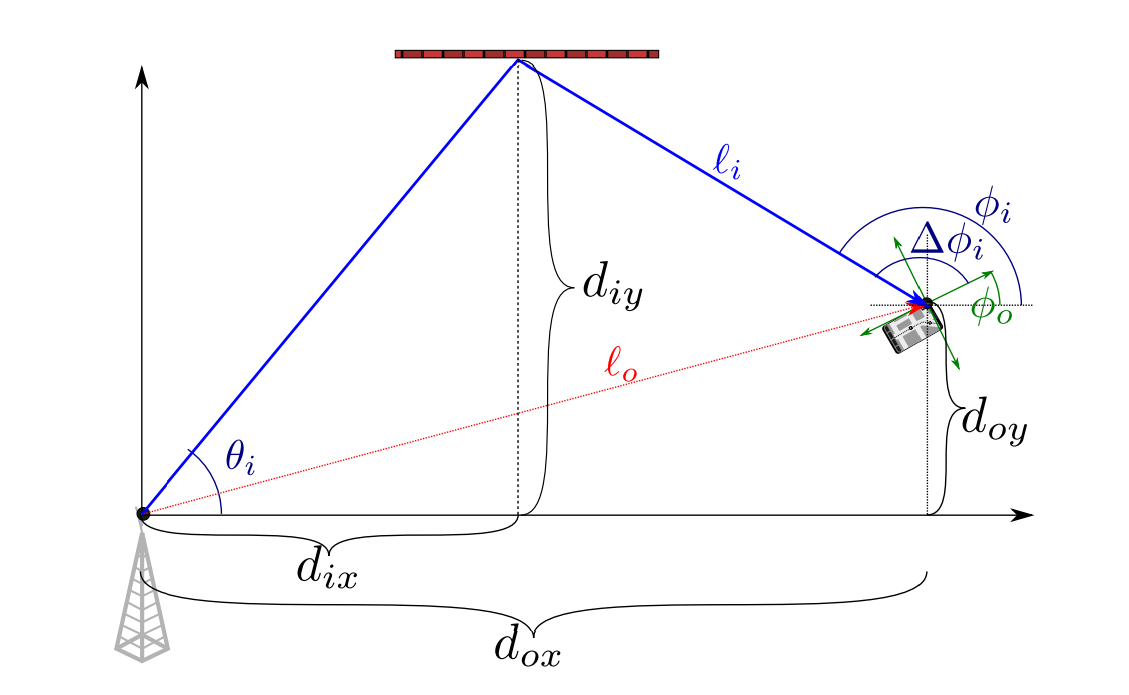

The figure above shows the characterization of a single reflection for the $i$-th path, as well as the UE parameters to be estimated. The reflector location $(d_{ix},d_{iy})$ can also be extracted with some algoritms for Simultaneous Location And Mapping (SLAM). In the figure, the UE position is related to just using one scatter, that simulates a single multipath reflection. Moreover, the location is retrieved relative to the BS location, used as reference with coordinates $(0,0)$.


Even with a single reflector, we can define two types of paths:

- *LOS path*: line of sight path, which may be a propagation path in LOS channels or be absent in NLOS channels.
- *NLOS path*: non line of sight propagation path, which contains a single scatter in first order paths. Higher order paths may be present in propagation environments, but they are not taken into account in the location algoritm.

The constraints and notation of the UE location parameters are:

- $d_{ox}$: coordinate x of the UE location
- $d_{oy}$: coordinate y of the UE location
- $\phi_o$: offset angle orientation, measured in the UE from the x-axis
- $\phi_{Do}$: AoD of the LOS path from the BS
\begin{equation}
\phi_{Do} = \begin{cases}
    arctan\left(\frac{d_{oy}}{d_{ox}}\right)& d_{ox}\geq 0\\
    arctan\left(\frac{d_{oy}}{d_{ox}}\right)+\pi& d_{ox}< 0
    \end{cases}
\end{equation}
- $\ell_o$: LOS path length
\begin{equation}
\ell_o = \sqrt{d_{ox}^2+d_{oy}^2}=\frac{d_{0y}}{sin(\phi_{Do})}
\end{equation}
- $c$: light speed (3e8 m/s)
- $\tau_o$: signal delay propagation in the LOS path
\begin{equation}
\tau_o = \frac{\ell_o}{c}
\end{equation}
- $d_{ix}$: coordinate x of the $i$-th scatter
- $d_{iy}$: coordinate y of the $i$-th scatter
- $\phi_{Di}$: AoD of the $i$-th NLOS path measured in the BS from the x-axis
\begin{equation}
\phi_{Di} = \begin{cases}
    arctan\left(\frac{d_{iy}}{d_{ix}}\right)& d_{ix}\geq 0\\
    arctan\left(\frac{d_{iy}}{d_{ix}}\right)+\pi& d_{ix}< 0
    \end{cases}
\end{equation}
- $\phi_{Ai}$: AoA of the NLOS ray measured in the BS from the x-axis
\begin{equation}
\phi_{Ai} = \begin{cases}
    arctan\left(\frac{d_{iy}-d_{oy}}{d_{ix}-d_{ox}}\right)& d_{ix}\geq d_{ox}\\
    arctan\left(\frac{d_{iy}-d_{oy}}{d_{ix}-d_{ox}}\right)+\pi& d_{ix} < d_{ox}
    \end{cases}
\end{equation}
- $\Delta \phi_{Ai}=\phi_{Ai}-\phi_{Ao}$: Difference Azimut Of Arrival (DAoA) of the NLOS path, measured in the UE from it's Local Coordinate System (LCS) from the direction $\phi_{Ao}$.
- $\ell_i$: length of the $i$-th NLOS path
\begin{equation}
\ell_i = \sqrt{d_{ix}^2+d_{iy}^2}+\sqrt{(d_{ix}-d_{ox})^2+(d_{iy}-d_{oy})^2}=\frac{d_{iy}}{sin(\phi_{Di})}+\frac{d_{iy}-d_{oy}}{sin(\Delta\phi_{Ai}+\phi_{Ao})}
\end{equation}
- $\tau_i$: signal delay propagation in the NLOS path
\begin{equation}
\tau_i = \frac{\ell_i}{c}
\end{equation}
- $\Delta \tau_i = \tau_i - \tau_e $: TDoA of the NLOS path, measured at the UE with a clock offset $\tau_e$ which may exceed $\tau_o$ if the LOS path is not visible or if there are synchronization errors.

# 2. Representation of a single path

For this first approach, we are going to replicate <a href="#Figure">theoretical</a> system representation. With this aim, we generate one UE position $(d_{ox}, d_{oy})$ and one reflector location $(d_{ix}, d_{iy})$. However we will store the data in numpy variables with dimesions $N_{path} × N_{user} = 1 \times 1$ for later compatibility. Both locations are randomly uniformly distributed in a square of size of $100 \times 100$ m that simulates the map where UE, BS and scatter are placed.

Moreover, we are going to plot the absolute AoA and AoD angles measured from the x-axis as explained in <a href="#1.1">1.1 section</a>, by omitting the terminal orientation for now $\phi_{Ao} = 0$.

In [1]:
#Import to use NumPy arrays
import numpy as np

#Import for making plots 
import matplotlib.pyplot as plt

#Plot size
plt.rcParams["figure.figsize"] = (18, 18)

#Plot page style, rerun this cell if it doesnt work
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Number of scattering paths (number of scatters)
Npath = 1

# Number of total users allocated in the plane
Nuser = 1

# We generate a random location for one user in a 100m [-50 y 50] square
d_0x = np.random.rand(Nuser)*100 - 50
d_0y = np.random.rand(Nuser)*100 - 50

print("d_0x = ",d_0x[0])
print("d_0y = ",d_0y[0])

d_0x =  -38.797724206918815
d_0y =  45.19694315078905


In [2]:
# We generate Npath random locations for scatters in a 50m [-50 y 50] square
# We place one scatter in each NLOS path
d_ix = np.random.rand(Npath,Nuser)*100 - 50
d_iy = np.random.rand(Npath,Nuser)*100 - 50

print("d_ix = ",d_ix[0][0])
print("d_iy = ",d_iy[0][0])

d_ix =  -46.30889224000331
d_iy =  -26.834051830602224


In [3]:
# All angles are in radians units
# With el mod operator, we ensure all angles are represented in their equivalent values from 0 to 2pi
AoD_0 = np.arctan(d_0y/d_0x)
AoD_0 = np.mod(AoD_0 + np.pi*(d_0x < 0), 2*np.pi)

AoD_i = np.arctan(d_iy/d_ix)
AoD_i = np.mod(AoD_i + np.pi*(d_ix < 0), 2*np.pi)

AoA_i = np.arctan((d_iy - d_0y)/(d_ix - d_0x))
AoA_i = np.mod(AoA_i + np.pi*((d_ix - d_0x) < 0), 2*np.pi)

print("AoD_0 = ",np.rad2deg(AoD_0[0]), "º")
print("AoD_i = ",np.rad2deg(AoD_i[0][0]), "º")
print("AOA_i = ",np.rad2deg(AoA_i[0][0]), "º")

AoD_0 =  130.6432791558007 º
AoD_i =  210.09048460816672 º
AOA_i =  264.0468895597116 º


In [4]:
# Ligth speed
c = 3e8

# LOS path length
l_0 = abs(d_0y/np.sin(AoD_0))

# LOS path time delay
tau_0 = l_0/c

# NLOS path time delay
l_i = np.abs(d_iy/np.sin(AoD_i)) + np.abs((d_iy - d_0y)/np.sin(AoA_i))
tau_i = l_i/c

# Delay difference between LOS and NLOS paths
TDoA_i = tau_i - tau_0

print("tau_0 = ",tau_0[0]*1e9, "ns")
print("tau_i = ",tau_i[0][0]*1e9, "ns")
print("TDoA_i = ",TDoA_i[0][0]*1e9, "ns")

tau_0 =  198.55105903105434 ns
tau_i =  419.8110883897569 ns
TDoA_i =  221.26002935870255 ns


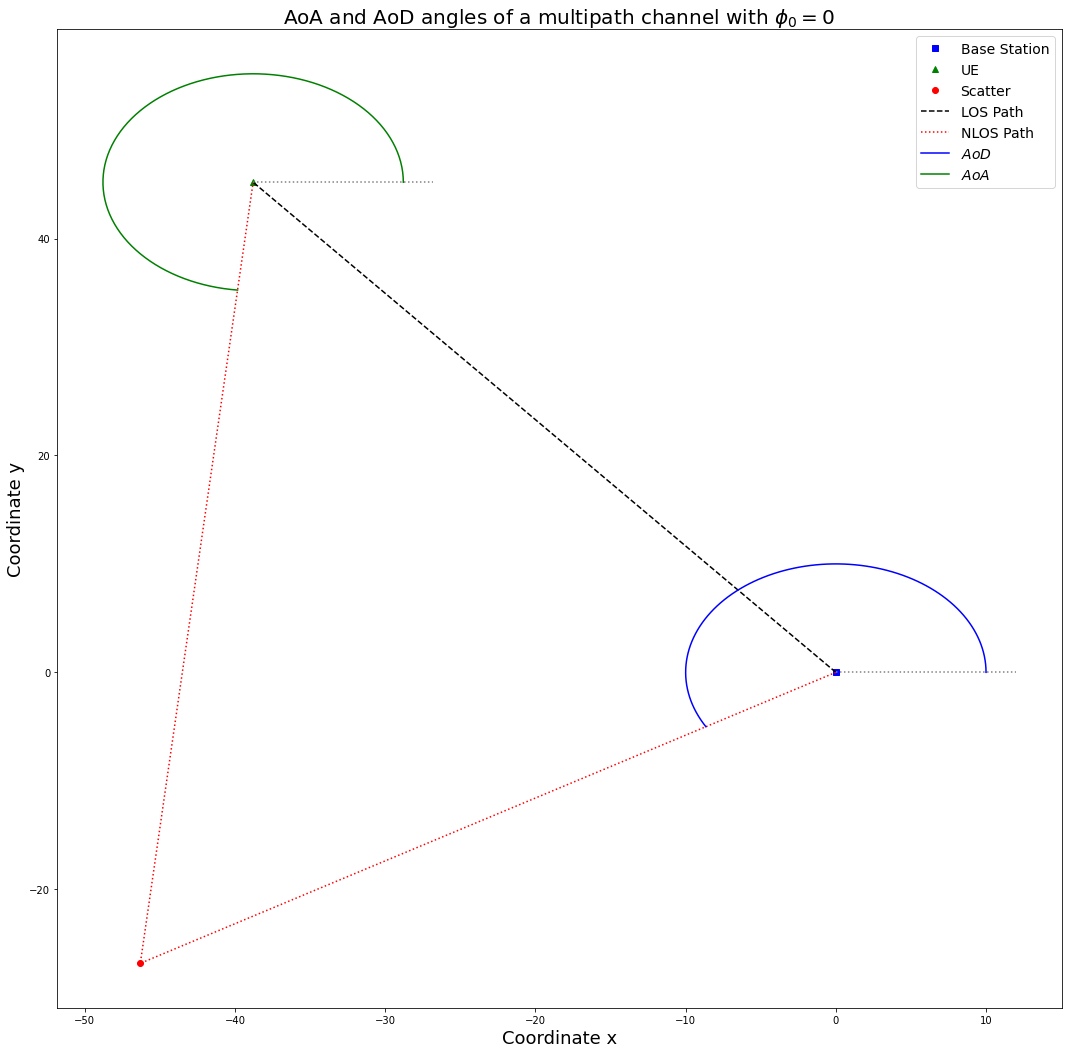

In [5]:
plt.figure(2)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot the scatter
plt.plot(d_ix, d_iy, "or", label="Scatter")

# Plot LOS path
plt.plot([[0],d_0x], [[0],d_0y], "--k", label="LOS Path")

# Plot NLOS path
plt.plot([[0],d_ix[0],d_0x], [[0],d_iy[0],d_0y], ":r", label="NLOS Path")

# Number of points to draw angles circunferences and size respect each origin (Base Station or UE)
circle_points = 100
circle_scale = 10
t = np.linspace(0, 1, circle_points)

# Plot x axis reference line in the Base Station
plt.plot([0, circle_scale + 2], [0,0], ":", color="grey")

# Plot x axis reference line in the UE
plt.plot([d_0x, d_0x + circle_scale + Npath*2], [d_0y,d_0y], ":" ,color="grey")
 
# Plot AoD angle
plt.plot(0 + (circle_scale)*np.cos(AoD_i[0]*t), 0 + (circle_scale)*np.sin(AoD_i[0]*t), "b" ,label="$AoD$")

# Plot AoA angle
plt.plot(d_0x + (circle_scale)*np.cos((AoA_i[0])*t), d_0y + (circle_scale)*np.sin((AoA_i[0])*t), "g", label="$AoA$")
    
plt.title("AoA and AoD angles of a multipath channel with $\phi_0=0$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Make and plot legend
plt.legend(prop={"size": 14})

# 3. One multipath ray with random UE orientation

In this second approach part, we are going to take in account UE orientation, generated randomly $\phi_0\sim U(0, 2\pi)$. The rest of parameters are kept identically regarding the section above. We only have to recalculate DAoA for the new value of $\phi_0$. Therefore, we depict:

-One multipath channel
-One scatter  
-One UE  
-The UE orientation $\phi_0$

In [6]:
# We generate a random angle for UE offset
phi_0 = np.random.rand(1)*2*np.pi
DAoA_i = np.mod(AoA_i - phi_0, 2*np.pi)

print("phi_0 = ",np.rad2deg(phi_0[0]), "º")
print("AoA_i = ",np.rad2deg(AoA_i[0][0]), "º")
print("DAoA_i = ",np.rad2deg(DAoA_i[0][0]), "º")

phi_0 =  309.1699993662402 º
AoA_i =  264.0468895597116 º
DAoA_i =  314.8768901934714 º


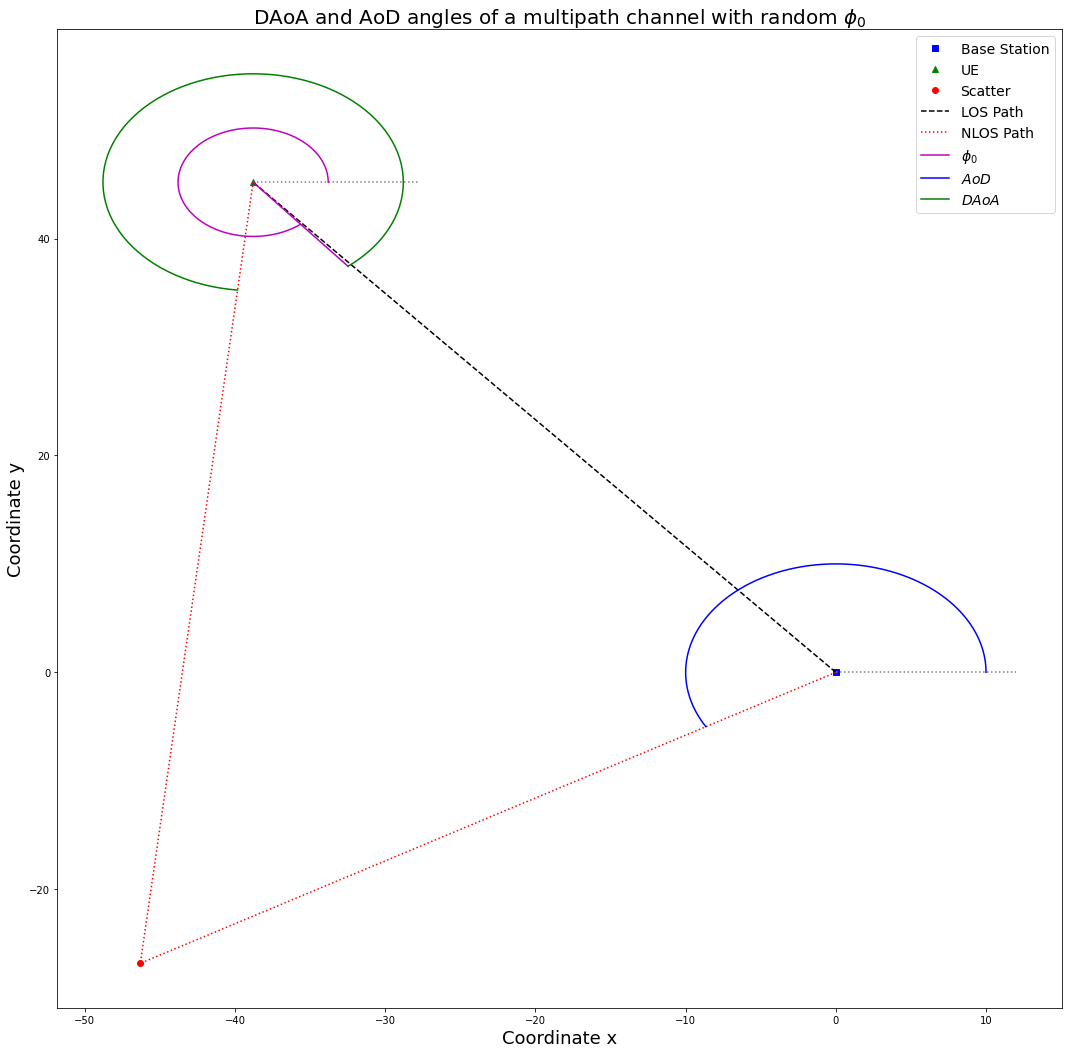

In [7]:
plt.figure(3)

# Plot the Base Station
plt.plot(0, 0, "sb", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot the scatter
plt.plot(d_ix, d_iy, "or", label="Scatter")

# Plot LOS path
plt.plot([0,d_0x[0]], [0,d_0y[0]], "--k", label="LOS Path")

# Plot NLOS path
plt.plot([0,d_ix[0,0],d_0x[0]], [0,d_iy[0,0],d_0y[0]], ":r", label="NLOS Path")

# Number of points to draw angles circunferences and size respect each origin (Base Station or UE)
circle_scale = 10
circle_points = 100
t = np.linspace(0, 1, circle_points)

# Plot x axis reference lines
plt.plot([0, circle_scale + Npath*2], [0,0], ":", color="grey")
plt.plot([d_0x, d_0x + circle_scale + Npath], [d_0y,d_0y], ":", color="grey")

# Plot phi_0 reference line
plt.plot([d_0x, d_0x + np.cos(phi_0)*circle_scale], [d_0y, d_0y + np.sin(phi_0)*circle_scale], color="m")

# Plot phi_0 angle
plt.plot(d_0x + (circle_scale/2)*np.cos((phi_0)*t), d_0y + (circle_scale/2)*np.sin((phi_0)*t), color="m" ,label="$\phi_0$")

# Plot AoD angle
plt.plot(0 + (circle_scale)*np.cos(AoD_i[0]*t), 0 + (circle_scale)*np.sin(AoD_i[0]*t), color="b", label="$AoD$")

# Plot AoA angle
x = np.array([(circle_scale)*np.cos(DAoA_i[0]*t)])
y = np.array([(circle_scale)*np.sin(DAoA_i[0]*t)])

rotated = np.concatenate((x, y), axis=0)

newX = rotated[0,:] * np.cos(phi_0) - rotated[1,:] * np.sin(phi_0)
newY = rotated[0,:] * np.sin(phi_0) + rotated[1,:] * np.cos(phi_0)

plt.plot(d_0x + newX, d_0y + newY, color="g",label="$DAoA$")

plt.title("DAoA and AoD angles of a multipath channel with random $\phi_0$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Make and plot legend
plt.legend(prop={"size": 14})

# 4. N multipath rays with common UE orientation offset

In our notebook, we assume a “constant offset” representation the channel parameters. We have talked about $\phi_0$, but not about the role it plays in the location estimation problem. 

In a location algorithm, we will assume that the multipath values AoD, DAoA and TDoA have been obtained from a pre-existing channel estimation technique. However, DAoA and TDoA should be converted to the global values AoA and $\tau_i$ before the location can be resolved. Additionally, for this framework, the angle and clock offset due to receiver orientation is the same for all paths. At this stage, we do not model individual measurement noise components that are independent in each path measurement.

- In first place, AoD is not affected by an offset, as the BS is the origin of the coordinates and its orientation is known
\begin{equation}
AoD = \phi_{Di}
\end{equation}
- On the order hand, the absolute AoA will not be as easy to compute. It's also directly related with the trigonometrical value of DAoA$_i$, but we will need to estimate the value of $\phi_0$ which can affect AoA measurement in UE
\begin{equation}
\Delta\phi_{Ai} = \phi_{Ai} - \phi_0
\end{equation}
- For the last parameter, $\Delta \tau_i$, we will talk more in the following tutorial where we introduce possible clock offset error present in separated devices. For this tutorial, we compute $\Delta \tau_i$ value as the propagation time between LOS and NLOS paths.
\begin{equation}
\Delta \tau_i = \tau_i -\tau_0
\end{equation}

For this last representation, we are going to generate one UE position $(d_{0x}, d_{0y})$ and $Npath × Nuser = 5×1$ reflector locations $(d_{ix}, d_{iy})$, both randomly uniformly distributed in a square of size of $100 \times 100$ m following the same base as the previous sections. We depict:

- One UE
- N scatters
- N multipath components belonging to a single UE channel
- The offset orientation $\phi_0$

In [8]:
# Number of Multipath paths, also the number of scatters
Npath = 5

#We generate a random location for one user in a 100m [-50 y 50] square
d_0x = np.random.rand(Nuser)*100 - 50
d_0y = np.random.rand(Nuser)*100 - 50

#We generate Npath random locations for scatters in a 50m [-50 y 50] square
d_ix = np.random.rand(Npath,Nuser)*100 - 50
d_iy = np.random.rand(Npath,Nuser)*100 - 50

In [9]:
# All angles are in radians units
# With el mod operator, we substract 2pi from the angle if it is higher than 2pi
AoD_0 = np.arctan(d_0y/d_0x)
AoD_0 = np.mod(AoD_0 + np.pi*(d_0x < 0), 2*np.pi)

AoD_i = np.arctan(d_iy/d_ix)
AoD_i = np.mod(AoD_i + np.pi*(d_ix < 0), 2*np.pi)

AoA_i = np.arctan((d_iy - d_0y)/(d_ix - d_0x))
AoA_i = np.mod(AoA_i + np.pi*((d_ix - d_0x) < 0), 2*np.pi)

#We generate a SINGLE random angle for UE offset
phi_0 = np.random.rand(1)*2*np.pi

DAoA_i = np.mod(AoA_i - phi_0, 2*np.pi)

print("phi_0 = ",np.rad2deg(phi_0[0]), "º")
print("AoD_i = ",np.rad2deg(AoD_i[:,0].T), "º")
print("AoA_i = ",np.rad2deg(AoA_i[:,0]), "º")
print("DAoA_i = ",np.rad2deg(DAoA_i[:,0]), "º")

phi_0 =  303.24035878050995 º
AoD_i =  [296.57017142  52.98180456  49.84825776 280.11549132 248.72575581] º
AoA_i =  [294.22984771 311.41814953   8.4736721  285.90733295 273.09662016] º
DAoA_i =  [350.98948893   8.17779075  65.23331332 342.66697417 329.85626138] º


In [10]:
# Ligth speed
c = 3e8

# LOS path length
l_0 = abs(d_0y/np.sin(AoD_0))

# LOS path time delay
tau_0 = l_0/c

# NLOS path time delay
l_i = np.abs(d_iy/np.sin(AoD_i)) + np.abs((d_iy - d_0y)/np.sin(AoA_i))
tau_i = l_i/c

# Delay difference between LOS and NLOS paths
TDoA_i = tau_i - tau_0

print("tau_0 = ",tau_0[0]*1e9, "ns")
print("tau_i = ",tau_i[:,0]*1e9, "ns")
print("TDoA_i = ",TDoA_i[:,0]*1e9, "ns")

tau_0 =  126.52772478280522 ns
tau_i =  [278.12464497 152.84578653 355.97797406 426.95350112 316.90927747] ns
TDoA_i =  [151.59692019  26.31806175 229.45024927 300.42577633 190.38155269] ns


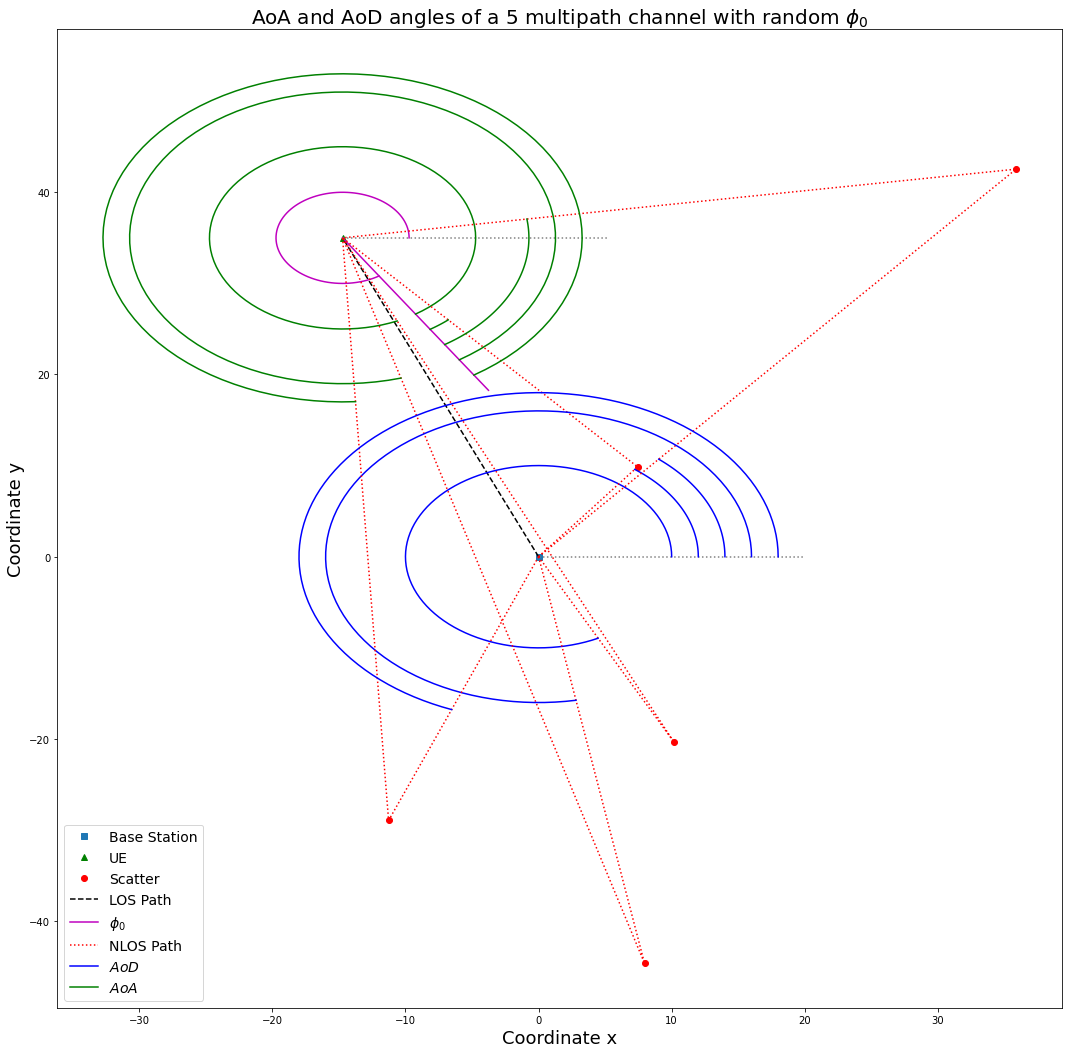

In [11]:
plt.figure(5)

# Plot the Base Station
plt.plot(0, 0, "s", label="Base Station")

# Plot the user
plt.plot(d_0x, d_0y, "^g", label="UE")

# Plot the scatter
plt.plot(d_ix, d_iy, "or", label="Scatter")

# Plot LOS path
plt.plot([0,d_0x[0]], [0,d_0y[0]], "--k", label="LOS Path")

# Number of points to draw angles circunferences and size respect each origin (Base Station or UE)
circle_scale = 10
circle_points = 100
t = np.linspace(0, 1, circle_points)

# Plot x axis reference lines
plt.plot([0, circle_scale + Npath*2], [0,0], ":", color="grey")
plt.plot([d_0x, d_0x + circle_scale + Npath*2], [d_0y,d_0y], ":", color="grey")

# Plot phi_0 reference line
plt.plot([d_0x, d_0x + np.cos(phi_0)*(circle_scale+Npath*2)], [d_0y, d_0y + np.sin(phi_0)*(circle_scale+Npath*2)], color="m")

# Plot phi_0 angle
plt.plot(d_0x + (circle_scale/2)*np.cos((phi_0)*t), d_0y + (circle_scale/2)*np.sin((phi_0)*t), color="m", label="$\phi_0$")


for p in range(Npath):
    
    # Plot NLOS paths
    plt.plot([0,d_ix[p,0],d_0x[0]], [0,d_iy[p,0],d_0y[0]], ':r', label="NLOS Path")
    
    # Plot AoD angles
    plt.plot(0 + (circle_scale + p*2)*np.cos(AoD_i[p,0]*t), 0 + (circle_scale + p*2)*np.sin(AoD_i[p,0]*t), color="b", label="$AoD$")
    
    # Plot AoA angles
    x = np.array([(circle_scale + p*2)*np.cos(DAoA_i[p,0]*t)])
    y = np.array([(circle_scale + p*2)*np.sin(DAoA_i[p,0]*t)])
    
    rotated = np.concatenate((x, y), axis=0)
    
    newX = rotated[0,:] * np.cos(phi_0) - rotated[1,:] * np.sin(phi_0)
    newY = rotated[0,:] * np.sin(phi_0) + rotated[1,:] * np.cos(phi_0)
    
    plt.plot(d_0x + newX, d_0y + newY, color="g", label="$AoA$")

plt.title("AoA and AoD angles of a " + str(Npath) + " multipath channel with random $\phi_0$", fontsize=20)
plt.xlabel("Coordinate x", fontsize=18)
plt.ylabel("Coordinate y", fontsize=18)

# Create and avoid label repetitions in the legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={"size": 14})

<span style="color:black; font-size:33px; font-family: Cambria"><b> 3. References </b></span>
<br>
<a class="anchor" id="References"></a>

[1] Felipe Gomez-Cuba. Multipath absolute clock recovery and location. page 12.

[2] Felipe Gómez-Cuba, Nuria González-Prelcic, and Gonzalo Feijoo Rodríguez. Clock and orientation-robust location and mapping from multipath channel estimation. page 6.